# AIM 5001 Project 2
## Weissman, Ramlakhan, Singh

### 1) Introduction 

We have chosen to utilize data from a database of the work schedules for a group home, where a team member, Nosson Weissman, is employed in Brooklyn, New York. This residential facility is designed to house and assist adults with cognitive development disabilities. As such, great care must be given to the training and staffing of the institution at all times. There are 26 employees and 12 full-time residents. The residents are rated by their level of difficulty on a scale from 1-10. The staff is required to perform residential maintenance tasks as well as supporting residents in their daily activities and living. The data we have used consists of AM and PM shift schedules for the month of July 2019. Our goal, the research question, is to verify if the current rating system is accurate based on the provided data. This is important to ensure optimal quality care for residents, we require that the most experienced employees are scheduled with the most challenging residents. 



### 2) Data Summary: 
The data used for this project consists of written schedules, provided by the group home. This data was manually entered into a CSV file. Then loaded into the SQL database, shift_info, that we have set up. The data in total comprises two types of shifts AM and PM. There are 23 AM shifts, 19 PM shifts. This is a Jewish affiliated institution, so that there are no Friday PM shifts. For the purposes of simplicity and using consistent data patterns, we do not include weekends. The schedules for weekends are dramatically different. The use case of this data is essentially timetabling to ensure that the right staff is scheduled with the residents by challenging score. 


### 3) Data Management Using PostgreSQL:

For this project we started with MySQL datbase which we then converted to Postgres
In order to successfully tranform the database, a considerable number of modifications had to be made both syntactically in addition to constraints which we had to introduce which were not needed in MySQL. We then rewrote inserts, selects, and necessary SQL statments to input the SQL schedule data which we had manually entered to the CSV. 
In addition to the SQL statments, we needed to sanitize some of the data from the CSV, for example whitespace characters which were connected with some of the comma deliminated residents' names.
Finally, we ran the SQL inserts and loaded all of data into our Postgres database.

In [65]:
import numpy as np
import pandas as pd
import psycopg2 as pg

In [66]:
conn = pg.connect(
    host="localhost",
    port="5433",
    database="shift_info",
    user="postgres",
    password="Riteintherain1",
    sslmode="disable")

In [67]:
# pandatable = pd.read_sql_query("""SELECT * FROM "employees" """, conn)
pandatable = pd.read_sql_query("""SELECT e."Firstname" AS Firstname, e."Lastname" AS Lastname, s."FireDuty" AS "FireDuty", s."Floorwatch" as       "FloorWatch", s."HouseDuty" AS "SideJob" FROM schedulenames sn, schedules s, employees e
    WHERE sn."ScheduleName"  = 'Wed_September_2_PM2020'
    AND s."ScheduleID" = sn."ScheduleID"
    AND e."EmpID" = s."EmpID"
    ORDER BY e."Lastname" ASC""", conn)

In [68]:
print(pandatable)

  firstname    lastname   FireDuty FloorWatch             SideJob
0  Yitzchok  * TRIAL *     Firebox         --                AMAP
1    Yaakov     Abeaziz  3rd Floor         --            Bookbags
2    Aubrey       Denny  1st Floor   Late 3rd  * TRIAL * TRIAL * 
3     Yosef     Gerecht  2nd Floor         --             Kitchen
4       Ben        Gill  1st Floor   Late 2nd             Kitchen
5      Abie     Hamaoui  * TRIAL *   Late 3rd            * TRIAL 
6     James        Kemp   * TRIAL   * TRIAL *        Van Clean Up
7    Nosson    Weissman  * TRIAL *         --          Sanitizing


In [69]:
pandatable = pd.read_sql_query("""SELECT * FROM houseduties""", conn)

In [70]:
print(pandatable)

    DutyID            DutyName  DutyDifficulty DutyShiftType
0        1                  --               0         Other
1        3             Kitchen               6            PM
2        4            Bookbags               4            PM
3        5          Restocking               4       Shabbos
4        6          * TRIAL *                2            PM
5        7        Van Clean Up               3            PM
6       16  Boxes and Garbages               5            PM
7       17                AMAP               8            PM
8       18             Lunches               6            PM
9       19           Something               5            PM
10      20             Kitchen               6            PM
11      21         First Floor               4            PM
12      22                Vans               3            PM
13      23   Boxes and Garbage               3            PM
14      24             Lunches               7            PM
15      25            Bo

In [71]:
pandatable = pd.read_sql_query("""SELECT * FROM participants""", conn)

In [72]:
print(pandatable)

    ParticID Firstname Lastname Initials  IsScipd  EnergyRequired
0          1  Chananya        R       CR        0               4
1          2     Duvid        F       DF        1               5
2          3       Ari        E       AE        0               6
3          4     Zisha        W       ZW        1               4
4          5     Yitzy        M       YM        0               3
5          6     Simho        I       SI        0               7
6          7    Mendel        B       MB        0               5
7          8  * TRIAL         F       YF        0               3
8          9  Yitzchok        E       YE        0               4
9         10  Binyamin        C       BC        0               6
10        11     Mendy        F       MF        0               7
11        12    Nussie        L       NL        0               8
12        13     Volvy        W       VW        0               3


In [76]:
import re
import pandas as pd
import csv

    
set_of_schedule_dates = set()

def get_schedule_id(schedule_date, shift_type):
    shift_type = shift_type.strip()
    schedule_date = schedule_date.strip()
    schedule_name = schedule_date+shift_type
    sched_id = pd.read_sql_query("""SELECT "ScheduleID" FROM schedulenames WHERE "ScheduleName" = '%s';""" % (schedule_name),
                            conn)
    if schedule_name not in set_of_schedule_dates and (len(sched_id['ScheduleID']) == 0):
        cursor = conn.cursor()
        cursor.execute("""INSERT INTO schedulenames  ("ScheduleName", "ScheduleType", "DateCreated") 
            VALUES('%s', '%s', '%s')""" %(schedule_name, shift_type, schedule_date))
        conn.commit() 
        cursor.close()
        set_of_schedule_dates.add(schedule_name)
    sched_id = pd.read_sql_query("""SELECT "ScheduleID" FROM schedulenames WHERE "ScheduleName" = '%s'; """ % (schedule_name),
                            conn)
    return sched_id['ScheduleID'][0]

def get_emp_id(first_name, last_name=''):
    emp_id = pd.read_sql_query("""SELECT "EmpID" FROM employees WHERE "Firstname" = '%s' AND "Lastname" = '%s' ;""" %(first_name, last_name), conn)
    if len(emp_id['EmpID']) == 0:
        cursor = conn.cursor()
        cursor.execute("""INSERT INTO employees  ("Firstname", "Lastname") 
            VALUES('%s', '%s')""" % (first_name, last_name))
        conn.commit() 
        cursor.close()
    emp_id = pd.read_sql_query("""SELECT "EmpID" FROM employees WHERE "Firstname" = '%s' AND "Lastname" = '%s' ;""" %(first_name, last_name), conn)
    return emp_id['EmpID'][0]

def get_duty_id(house_duty, shift_type):
    duty_id = pd.read_sql_query("""SELECT "DutyID" FROM houseduties WHERE "DutyName" = '%s' AND "DutyShiftType" = '%s' ;""" 
                                %(house_duty, shift_type), conn)
    if len(duty_id['DutyID']) == 0:
        cursor = conn.cursor()
        duty_id = cursor.execute("""INSERT INTO houseduties  ("DutyName", "DutyDifficulty", "DutyShiftType") 
            VALUES('%s', %d, '%s');""" % (house_duty, 5, shift_type))
        conn.commit() 
        cursor.close()
    duty_id = pd.read_sql_query("""SELECT "DutyID" FROM houseduties WHERE "DutyName" = '%s' AND "DutyShiftType" = '%s' ;""" 
                                %(house_duty, shift_type), conn)
    return duty_id

def get_partic_id(partic_initials):
    partic_id = pd.read_sql_query("""SELECT "ParticID" FROM participants WHERE "Initials" = '%s';"""
                                %(partic_initials), conn)
    return partic_id['ParticID'][0]

def insert_record_to_schedule_table(schedule_id, emp_id, floor_watch, house_duty, fire_duty):
    cursor = conn.cursor()
    duty_id = cursor.execute("""INSERT INTO schedules  ("ScheduleID", "EmpID", "Floorwatch", "HouseDuty", "FireDuty") 
        VALUES(%d, %d, '%s', '%s', '%s');"""% (schedule_id, emp_id, floor_watch, house_duty, fire_duty))
    conn.commit()
    cursor.close()
    
def insert_schedule_pairing(schedule_id, emp_id, partic_id):
    partic_pairing = pd.read_sql_query("""SELECT "ScheduleID" FROM schedulepairings WHERE "ScheduleID" = %d AND "ParticID" = %d"""
                                %(schedule_id, partic_id), conn)
    
    if partic_pairing.empty:
        cursor = conn.cursor()
        duty_id = cursor.execute("""INSERT INTO schedulepairings ( "ScheduleID", "EmpID", "ParticID")
            VALUES (%d, %d, %d);""" % (schedule_id, emp_id, partic_id))
        conn.commit()
        cursor.close()

csvfile = open('C:\\Users\\Wesso\\Desktop\\Schedule Records - Sheet1.csv', "r")    
schedule_name_set = set()
for row in csv.reader(csvfile):
    regex_pattern = re.compile(r'[0-9]{4}\-[0-9]{2}\-[0-9]{2}')
    schedule_date = row[0]
    is_valid_data = len(regex_pattern.findall(schedule_date)) > 0
    partic_set = set(['NL', 'SI', 'VW', 'MF', 'DF', 'BC', 'MB', 'YE', 'YM', 'YF', 'AE', 'CR', 'ZW'])
    if is_valid_data:
        shift_type = row[1]
        staff_name = row[2]
        participant_names = row[3].split(',')
        duty_dict = {'SK': 'Kitchen',
            'BG': 'Boxes and Garbage',
            'PV': 'Vans',
            'M': 'AMAP',
            '1fl': 'First Floor',
            'K': 'Kitchen',
            'LS': 'Lunches',
            'YB': 'Bookbags',
            '1,2,3': 'First Floor'
        }
        
        house_duty = row[4] or ''
        if house_duty in duty_dict:
            house_duty = duty_dict[house_duty]
        fire_duty = row[5] or ''
        floor_watch = row[6] or ''
        schedule_id = get_schedule_id(schedule_date, shift_type)
        emp_id = get_emp_id(staff_name)
        duty_id = get_duty_id(house_duty, shift_type)
        insert_record_to_schedule_table(schedule_id, emp_id, floor_watch, house_duty, fire_duty)
        unique_partics = set()
        for i in range(len(participant_names)):
            partic = participant_names[i]
            partic = partic.strip()
            if partic not in unique_partics:
                if len(partic) > 0 and partic in partic_set:
                    partic_id = get_partic_id(partic)
                    insert_schedule_pairing(schedule_id, emp_id, partic_id)
            unique_partics.add(partic)
                                


### 4.) Exploratory Data Analysis 

Given that during the month of July we see a wide variance of experience levels of all employees and seemingly random work shifts, we can demonstrate that the system currently in place is inefficient. The information provided in the dataset that we use to gauge whether a particular shift being staffed appropriately is the combination of weights of DutyDifficulty in "houseduties" table which describes the effort necessary for the tasks for the home, the EnergyRequired in the "participants" table and the "experience" for the actual staff. We demonstrate with graphs the experience of employees and the shift difficulty bases on the combination of these calculation. 



In [77]:
schedules = pd.read_csv("our_schedules2.csv")
employees = pd.read_csv("employees.csv")
houseduties = pd.read_csv("houseduties.csv")
residents = pd.read_csv("participants.csv")

In [78]:
schedules

,ShiftDate,ShiftType,Staff,Residents,ResidentID,HouseDuty,HouseDutyID,FireDuty,FloorWatch
0,2019-07-01,AM,Shimshi,"DF, ZW","2, 4",NaN,1,1,NaN
1,2019-07-01,AM,Albert,"AE, CR","3, 1",NaN,1,2,NaN
2,2019-07-01,AM,Natasha,"MB, YE","7, 9",1fl,8,3,NaN
3,2019-07-01,AM,Nosson,"SI, VW","6, 11",K,8,B,NaN
4,2019-07-01,AM,Shaul,NaN,NaN,M,2,MA,NaN
...,...,...,...,...,...,...,...,...,...
278,2019-07-31,PM,Moshe,SI,6,LR,6,3,3l
279,2019-07-31,PM,David,"ZW,CR","4,1",YB,4,B,NaN
280,2019-07-31,PM,Aubrey,"DF,YF","2,8",SK,3,M,NaN
281,2019-07-31,PM,Sam,"MB,VW","7,11",LS,11,2,2l


In [79]:
employees

,EmpID,Name,Experience
0,1,Albert,16
1,2,Allen,56
2,3,Aubrey,32
3,4,Ben,12
4,5,Binyomin,23
5,6,Chaim,35
6,7,Daniel,56
7,8,David,13
8,9,Jay,24
9,10,Joey,23


In [80]:
houseduties

,DutyID,DutyName,DutyDifficulty,DutyShiftType
0,1,--,0,Other
1,2,AMAP,8,AM
2,3,Kitchen,6,PM
3,4,Bookbags,4,PM
4,5,Restocking,4,Shabbos
5,6,Living Room,2,PM
6,7,Van Clean Up,3,PM
7,8,House Help,1,AM
8,9,Boxes and Garbages,5,PM
9,10,AMAP,8,PM


In [81]:
residents

,ParticID,Firstname,Lastname,Initials,IsScipd,EnergyRequired
0,1,Chananya,R,CR,0,4
1,2,Duvid,F,DF,1,5
2,3,Ari,E,AE,0,6
3,4,Zisha,W,ZW,1,4
4,5,Yitzy,M,YM,0,3
5,6,Simho,I,SI,0,7
6,7,Mendel,B,MB,0,5
7,8,* TRIAL,F,YF,0,3
8,9,Yitzchok,E,YE,0,4
9,10,Binyamin,C,BC,0,6


In [82]:
number = re.compile('[0-9]+')

energydemand = []

for i in schedules.ResidentID:
    if type(i) == str:
        extract = number.findall(i)

        energysum = 0
        for j in extract:
            ind = int(j)
            energysum = energysum + residents.EnergyRequired[ind - 1]

        energydemand.append(energysum)
        
    else:
        energydemand.append(0)

# energydemand

In [83]:
len(energydemand) == len(schedules.ResidentID)

True

In [84]:
taskdemand = []

for i in schedules.HouseDutyID:
    taskdemand.append(houseduties.DutyDifficulty[i-1])

# taskdemand

In [85]:
len(energydemand) == len(schedules.ResidentID)

True

In [86]:
Load = np.array(energydemand) + np.array(taskdemand)

len(Load)

283

In [87]:
schedules.insert(9, "Load", Load)

schedules

,ShiftDate,ShiftType,Staff,Residents,ResidentID,HouseDuty,HouseDutyID,FireDuty,FloorWatch,Load
0,2019-07-01,AM,Shimshi,"DF, ZW","2, 4",NaN,1,1,NaN,9
1,2019-07-01,AM,Albert,"AE, CR","3, 1",NaN,1,2,NaN,10
2,2019-07-01,AM,Natasha,"MB, YE","7, 9",1fl,8,3,NaN,10
3,2019-07-01,AM,Nosson,"SI, VW","6, 11",K,8,B,NaN,15
4,2019-07-01,AM,Shaul,NaN,NaN,M,2,MA,NaN,8
...,...,...,...,...,...,...,...,...,...,...
278,2019-07-31,PM,Moshe,SI,6,LR,6,3,3l,9
279,2019-07-31,PM,David,"ZW,CR","4,1",YB,4,B,NaN,12
280,2019-07-31,PM,Aubrey,"DF,YF","2,8",SK,3,M,NaN,14
281,2019-07-31,PM,Sam,"MB,VW","7,11",LS,11,2,2l,18


In [88]:
employeeshifts = []
employeeloads = []

for i in employees.Name:
    shift = 0
    netload = 0
    
    for j in range(len(schedules.Staff)):
        if schedules.Staff[j] == i:
            shift += 1
            netload = netload + schedules.Load[j]
    
    employeeshifts.append(shift)
    employeeloads.append(netload)

In [89]:
employees.insert(3, "ShiftsWorked", employeeshifts)
employees.insert(4, "TotalLoad", employeeloads)


### 5.) Inference 

To answer the ultimate research question, we create a description of the called Load for the difficulty of each shift for the month. This will be then plotted against the work experience level of all unique employees of the data frame in Pandas. Examining the graphs of these we are then able to conclude whether or not the home in question is optimizing the level of experience and quality care for their residents. 



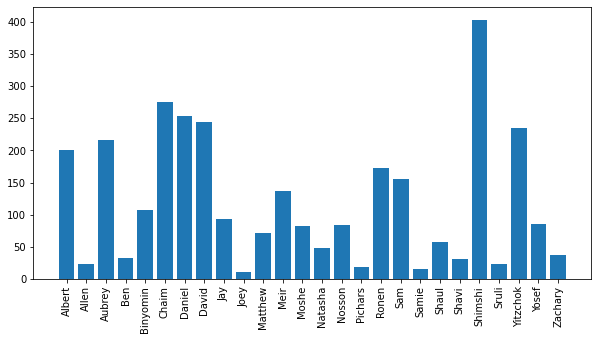

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(employees.Name, employees.TotalLoad)
plt.xticks(rotation=90)
plt.show()

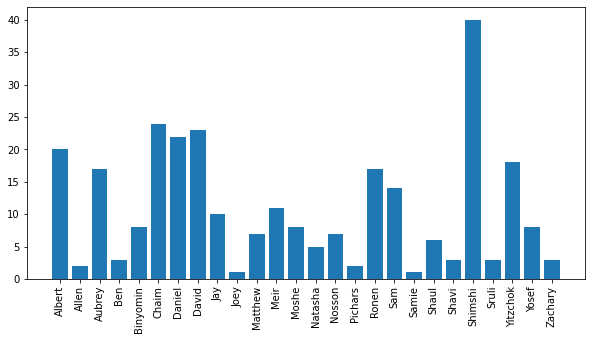

In [91]:
plt.figure(figsize=(10,5))
plt.bar(employees.Name, employees.ShiftsWorked)
plt.xticks(rotation=90)
plt.show()

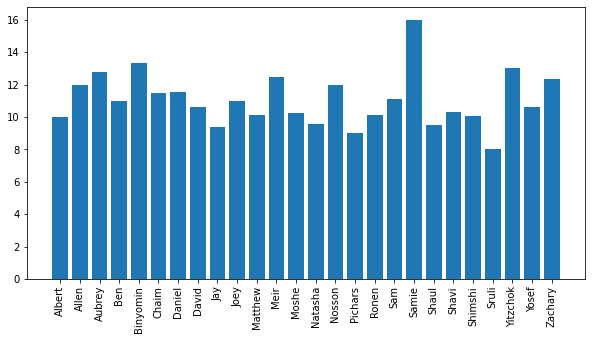

In [92]:
plt.figure(figsize=(10,5))
plt.bar(employees.Name, employees.TotalLoad/employees.ShiftsWorked)
plt.xticks(rotation=90)
plt.show()

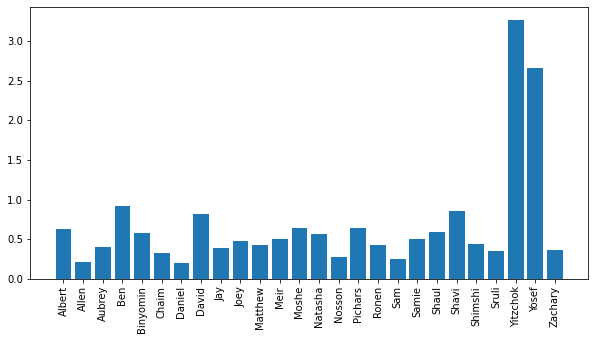

In [93]:
plt.figure(figsize=(10,5))
plt.bar(employees.Name, (employees.TotalLoad/employees.ShiftsWorked)/employees.Experience)
plt.xticks(rotation=90)
plt.show()


### 6.) Conclusion

This residential facility performs a necessary social function by providing quality services around the clock to several full time residents. To provide these services in conjunction with the Jewish faith, the facility schedules weekday shifts AM and PM from Monday to Thursday, and AM shifts on Friday. Weekend shifts, for simplicity, we do not analyze any data from the weekend shifts. The facility provided us with written schedules which we then manually input to several CSV files, which we then query into a new database in PostGreSQL and then we query it all into pandas data frame. From there we perform several data analysis graphics which we then demonstrate do not optimally fit the level of difficulty of each shift. The facility requires that employees perform a combination of one-on-one activity to the residents and housework as well as be on fire duty. The facility can make steps to improve quality care provided and optimize work by facilitating better scheduling through an automation process which we hope to achieve for the final project.   
